In [ ]:
# https://arxiv.org/pdf/2104.12259.pdf

In [3]:
import torch
vers = torch.__version__
print("Torch vers: ", vers)

# PyG installation
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

import torch_geometric

Torch vers:  2.0.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
from torch_geometric.datasets import UPFD
train_data = UPFD(root="/content/drive/MyDrive/Colab Notebooks/FakeNews/", name="gossipcop", feature="bert", split="train")
test_data = UPFD(root="/content/drive/MyDrive/Colab Notebooks/FakeNews/", name="gossipcop", feature="bert", split="test")
print("Train Samples: ", len(train_data))
print("Test Samples: ", len(test_data))
# feature="content" --> Spacy Word2Vec + Profile features

Train Samples:  1092
Test Samples:  3826


In [ ]:
# News Propogation Graph
sample_id=1
train_data[sample_id].edge_index

In [ ]:
import networkx as nx

# From PyG utils
def to_networkx(data, node_attrs=None, edge_attrs=None, to_undirected=False,
                remove_self_loops=False):
    if to_undirected:
        G = nx.Graph()
    else:
        G = nx.DiGraph()
    G.add_nodes_from(range(data.num_nodes))
    node_attrs, edge_attrs = node_attrs or [], edge_attrs or []
    values = {}
    for key, item in data(*(node_attrs + edge_attrs)):
        if torch.is_tensor(item):
            values[key] = item.squeeze().tolist()
        else:
            values[key] = item
        if isinstance(values[key], (list, tuple)) and len(values[key]) == 1:
            values[key] = item[0]
    for i, (u, v) in enumerate(data.edge_index.t().tolist()):
        if to_undirected and v > u:
            continue
        if remove_self_loops and u == v:
            continue
        G.add_edge(u, v)
        for key in edge_attrs:
            G[u][v][key] = values[key][i]
    for key in node_attrs:
        for i, feat_dict in G.nodes(data=True):
            feat_dict.update({key: values[key][i]})
    return G

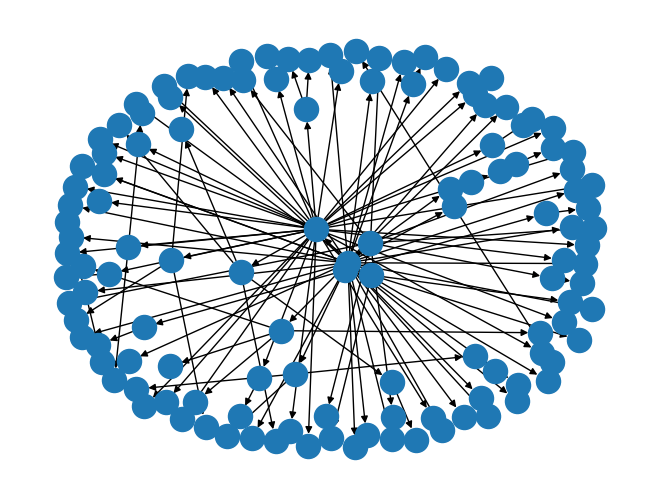

In [ ]:
nx.draw(to_networkx(train_data[sample_id]))

In [ ]:
# Node Fatures
print(train_data[sample_id].x.shape)
train_data[sample_id].x

In [ ]:
import pandas as pd
labels = [data.y.item() for i, data in enumerate(train_data)]
df = pd.DataFrame(labels, columns=["Labels"])
df["Labels"].hist()

In [ ]:
# GIN Convolution

In [ ]:
# Data Loaders
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [ ]:
# Model training
# Because it is a directed graph, it will only share information from the root
from torch_geometric.nn import global_max_pool as gmp
from torch.nn import Linear
from torch_geometric.nn import GINConv

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        # Graph Convolutions
        self.conv1 = GINConv(Linear(in_channels, hidden_channels))
        self.conv2 = GINConv(Linear(hidden_channels, hidden_channels))
        self.conv3 = GINConv(Linear(hidden_channels, hidden_channels))
        self.conv4 = GINConv(Linear(hidden_channels, hidden_channels))
        self.conv5 = GINConv(Linear(hidden_channels, hidden_channels))


        # Readout
        self.lin_news = Linear(in_channels, hidden_channels)
        self.lin0 = Linear(hidden_channels, hidden_channels)
        self.lin1 = Linear(2*hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # Graph Convolutions
        h = self.conv1(x, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        h = self.conv3(h, edge_index).relu()

        # Pooling
        h = gmp(h, batch) # global max pool

        # Readout
        h = self.lin0(h).relu()

        root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0)
        # root is e.g. [   0,   14,   94,  171,  230,  302, ... ]
        news = x[root]
        news = self.lin_news(news).relu()
        
        out = self.lin1(torch.cat([h, news], dim=-1))
        return torch.sigmoid(out)

GNN(train_data.num_features, 512, 1)

GNN(
  (conv1): GINConv(nn=Linear(in_features=768, out_features=512, bias=True))
  (conv2): GINConv(nn=Linear(in_features=512, out_features=512, bias=True))
  (conv3): GINConv(nn=Linear(in_features=512, out_features=512, bias=True))
  (conv4): GINConv(nn=Linear(in_features=512, out_features=512, bias=True))
  (conv5): GINConv(nn=Linear(in_features=512, out_features=512, bias=True))
  (lin_news): Linear(in_features=768, out_features=512, bias=True)
  (lin0): Linear(in_features=512, out_features=512, bias=True)
  (lin1): Linear(in_features=1024, out_features=1, bias=True)
)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(train_data.num_features, 512, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
loss_fnc = torch.nn.BCELoss()

def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs
        all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())

    # Calculate Metrics
    accuracy, f1 = metrics(all_preds, all_labels)

    return total_loss / len(test_loader.dataset), accuracy, f1


def metrics(preds, gts):
    preds = torch.round(torch.cat(preds))
    gts = torch.cat(gts)
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts)
    return acc, f1

In [ ]:
for epoch in range(80):
    train_loss = train(epoch)
    test_loss, test_acc, test_f1 = test(epoch)
    print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.2f} | '
          f'TestLoss: {test_loss:.2f} | TestAcc: {test_acc:.2f} | TestF1: {test_f1:.2f}')

Epoch: 00 |  TrainLoss: 0.66 | TestLoss: 0.65 | TestAcc: 0.59 | TestF1: 0.70
Epoch: 01 |  TrainLoss: 0.61 | TestLoss: 0.59 | TestAcc: 0.71 | TestF1: 0.69
Epoch: 02 |  TrainLoss: 0.57 | TestLoss: 0.57 | TestAcc: 0.72 | TestF1: 0.72
Epoch: 03 |  TrainLoss: 0.55 | TestLoss: 0.56 | TestAcc: 0.73 | TestF1: 0.72
Epoch: 04 |  TrainLoss: 0.53 | TestLoss: 0.56 | TestAcc: 0.73 | TestF1: 0.68
Epoch: 05 |  TrainLoss: 0.52 | TestLoss: 0.55 | TestAcc: 0.72 | TestF1: 0.73
Epoch: 06 |  TrainLoss: 0.50 | TestLoss: 0.55 | TestAcc: 0.71 | TestF1: 0.74
Epoch: 07 |  TrainLoss: 0.51 | TestLoss: 0.56 | TestAcc: 0.73 | TestF1: 0.67
Epoch: 08 |  TrainLoss: 0.50 | TestLoss: 0.57 | TestAcc: 0.69 | TestF1: 0.74
Epoch: 09 |  TrainLoss: 0.50 | TestLoss: 0.57 | TestAcc: 0.72 | TestF1: 0.65
Epoch: 10 |  TrainLoss: 0.51 | TestLoss: 0.53 | TestAcc: 0.74 | TestF1: 0.70
Epoch: 11 |  TrainLoss: 0.47 | TestLoss: 0.49 | TestAcc: 0.76 | TestF1: 0.75
Epoch: 12 |  TrainLoss: 0.43 | TestLoss: 0.45 | TestAcc: 0.78 | TestF1: 0.80

In [ ]:
for data in test_loader:
    data = data.to(device)
    pred = model(data.x, data.edge_index, data.batch)
    df = pd.DataFrame()
    df["pred_logit"] = pred.detach().numpy()[:,0]
    df["pred"] = torch.round(pred).detach().numpy()[:,0]
    df["true"] = data.y.numpy()
    print(df.head(10))
    break

   pred_logit  pred  true
0    0.051419   0.0     1
1    0.945040   1.0     1
2    0.003015   0.0     0
3    1.000000   1.0     1
4    0.450801   0.0     0
5    0.003827   0.0     0
6    0.004401   0.0     0
7    1.000000   1.0     1
8    0.017194   0.0     0
9    0.849178   1.0     0


GIN + CONTENT (4 Layers)



In [ ]:
from torch_geometric.datasets import UPFD
train_data = UPFD(root=".", name="gossipcop", feature="spacy", split="train")
test_data = UPFD(root=".", name="gossipcop", feature="spacy", split="test")
print("Train Samples: ", len(train_data))
print("Test Samples: ", len(test_data))


Processing...
Done!


Train Samples:  1092
Test Samples:  3826


In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GINConv, global_add_pool

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        # Graph Convolutions
        self.conv1 = GINConv(Linear(in_channels, hidden_channels))
        self.conv2 = GINConv(Linear(hidden_channels, hidden_channels))
        self.conv3 = GINConv(Linear(hidden_channels, hidden_channels))
        self.conv4 = GINConv(Linear(hidden_channels, hidden_channels))
        self.conv5 = GINConv(Linear(hidden_channels, hidden_channels))


        # Readout
        self.lin_news = Linear(in_channels, hidden_channels)
        self.lin0 = Linear(hidden_channels, hidden_channels)
        self.lin1 = Linear(2*hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # Graph Convolutions
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = self.conv2(h, edge_index)
        h = F.relu(h)
        h = self.conv3(h, edge_index)
        h = F.relu(h)
        h = self.conv4(h, edge_index)
        h = F.relu(h)
        h = self.conv5(h, edge_index)
        h = F.relu(h)

        # Pooling
        h = global_add_pool(h, batch) # global add pool

        # Readout
        h = self.lin0(h)
        h = F.relu(h)

        root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0)
        # root is e.g. [   0,   14,   94,  171,  230,  302, ... ]
        news = x[root]
        news = self.lin_news(news)
        news = F.relu(news)
        
        out = torch.cat([h, news], dim=-1)
        out = self.lin1(out)
        out = torch.sigmoid(out)
        return out


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(train_data.num_features, 512, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
loss_fnc = torch.nn.BCELoss()

def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs
        all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())

    # Calculate Metrics
    accuracy, f1 = metrics(all_preds, all_labels)

    return total_loss / len(test_loader.dataset), accuracy, f1


def metrics(preds, gts):
    preds = torch.round(torch.cat(preds))
    gts = torch.cat(gts)
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts)
    return acc, f1

In [ ]:
for epoch in range(50):
    train_loss = train(epoch)
    test_loss, test_acc, test_f1 = test(epoch)
    print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.2f} | '
          f'TestLoss: {test_loss:.2f} | TestAcc: {test_acc:.2f} | TestF1: {test_f1:.2f}')

Epoch: 00 |  TrainLoss: 0.85 | TestLoss: 0.65 | TestAcc: 0.74 | TestF1: 0.77
Epoch: 01 |  TrainLoss: 0.62 | TestLoss: 0.60 | TestAcc: 0.76 | TestF1: 0.76
Epoch: 02 |  TrainLoss: 0.59 | TestLoss: 0.59 | TestAcc: 0.76 | TestF1: 0.75
Epoch: 03 |  TrainLoss: 0.56 | TestLoss: 0.55 | TestAcc: 0.78 | TestF1: 0.77
Epoch: 04 |  TrainLoss: 0.54 | TestLoss: 0.55 | TestAcc: 0.78 | TestF1: 0.77
Epoch: 05 |  TrainLoss: 0.53 | TestLoss: 0.54 | TestAcc: 0.78 | TestF1: 0.78
Epoch: 06 |  TrainLoss: 0.50 | TestLoss: 0.52 | TestAcc: 0.75 | TestF1: 0.79
Epoch: 07 |  TrainLoss: 0.51 | TestLoss: 0.54 | TestAcc: 0.71 | TestF1: 0.77
Epoch: 08 |  TrainLoss: 0.51 | TestLoss: 0.49 | TestAcc: 0.78 | TestF1: 0.80
Epoch: 09 |  TrainLoss: 0.47 | TestLoss: 0.47 | TestAcc: 0.79 | TestF1: 0.81
Epoch: 10 |  TrainLoss: 0.46 | TestLoss: 0.50 | TestAcc: 0.81 | TestF1: 0.80
Epoch: 11 |  TrainLoss: 0.46 | TestLoss: 0.52 | TestAcc: 0.81 | TestF1: 0.80
Epoch: 12 |  TrainLoss: 0.43 | TestLoss: 0.45 | TestAcc: 0.82 | TestF1: 0.82